In [1]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
library(magrittr)
library(cowplot)
library(tidyverse)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

Loading required package: sysfonts
Loading required package: showtextdb
Warning message:
“package ‘rjags’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()


# Data loading and visualization

## Loading

In [2]:
data <- read.table("data/IC48A_AmCsCo.txt", col.names = c('Ch', 'counts')) 


## Visualization

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

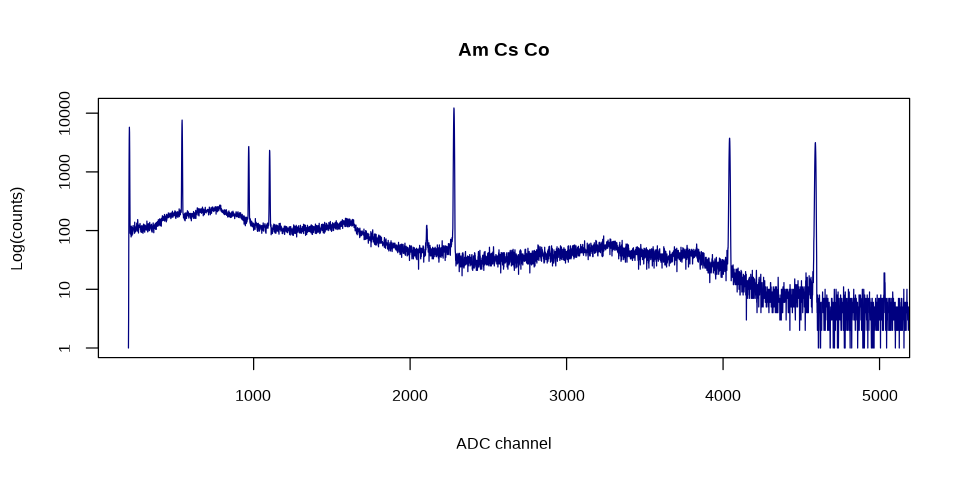

In [3]:
set_plot_dimensions(8, 4)

plot(data$Ch,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(200,5000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


## Additional  Information

In [4]:
#Add tble with the energies and so on, all what we will be needing/using along the notebook
#and is external

## Peak detection and characterization

In [5]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}

peak_shift <- function(peak_array){
    #fetches an array of counts with the peak at the center
    peak_idx <- which.max(peak_array)
    peak_y <- c(peak_array[(peak_idx-10):(peak_idx+10)])
    return(peak_y)
}

fetch_ch <- function(peak_array){
    #fetches indices of a particular peak as it exists in the elements of data_range
    peak_idx <- which.max(peak_array)
    idx_c <- c((peak_idx-10):(peak_idx+10))
    return(idx_c)
}

probe_peaks <- function(data, n.pts, pk_size){
    
    #split counts and channels into intervals of n.pts each
    data_range <- split(data$counts, ceiling(row(data)/n.pts))
    ch_range <- split(data$Ch, ceiling(row(data)/n.pts))
    
    #find the range of values for each interval established in data_range
    minmax_range <- lapply(data_range, range_size)
    
    #filter the counts to return peaks larger than a certain size.
    peaks <- data_range[minmax_range > pk_size]
    
    #applies functions to gather counts in each of the peaks, and their indices in data_range
    ly <- lapply(peaks, peak_shift)
    lx <- lapply(peaks, fetch_ch)
    
    #build dataframe of channel indices
    centered_ch <- bind_cols(lx)
    colnames(centered_ch) = paste('X', 1:length(lx), sep = '')
    
    #convert indices gathered from data_range to channel values according to ch_range
    for(i in seq_along(colnames(centered_ch))){
        centered_ch[[colnames(centered_ch)[i]]] = ch_range[[names(lx)[i]]][lx[[i]]]
    }
    
    #build dataframe of count values
    centered_peaks <- bind_cols(ly)
    colnames(centered_peaks) = paste('Y',1:length(ly), sep = '')
    
    #bind together channel values and count values, with "Xi" corresponding to "Yi", i = 1, 2, ...
    centered_ch %<>% cbind(centered_peaks)
    return(centered_ch)
}

centered_peaks <- probe_peaks(data, 80, 3500)

Warning message in split.default(data$counts, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”Warning message in split.default(data$Ch, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”

In [6]:
centered_peaks 

X1,X2,X3,X4,Y1,Y2,Y3,Y4
196,533,2270,4032,0,221,72,50
197,534,2271,4033,0,204,76,74
198,535,2272,4034,1,227,96,128
199,536,2273,4035,0,230,108,239
200,537,2274,4036,1,205,219,434
201,538,2275,4037,3,256,586,777
202,539,2276,4038,48,547,1400,1528
203,540,2277,4039,328,1570,3304,2232
204,541,2278,4040,1458,3904,6290,3065
205,542,2279,4041,3690,6510,9826,3683


# Peak processing 

In [7]:
t1 <- NULL
t1$x <- centered_peaks$X1[centered_peaks$Y1!=0]
t1$y <- centered_peaks$Y1[centered_peaks$Y1!=0]

t2 <- NULL
t2$x <- centered_peaks$X2
t2$y <- centered_peaks$Y2

t3 <- NULL
t3$x <- centered_peaks$X3
t3$y <- centered_peaks$Y3

t4 <- NULL
t4$x <- centered_peaks$X4
t4$y <- centered_peaks$Y4


peaks <-list(t1,t2,t3,t4)

[1] "peak 1"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
A  5439.107 49.947417 9.119e-01      9.317e-01
B     1.996  0.004315 7.878e-05      8.278e-05
w     1.390  0.008126 1.484e-04      1.509e-04
x0  206.219  0.010465 1.911e-04      1.825e-04

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  5344.260 5404.038 5439.211 5472.047 5538.753
B     1.984    1.994    1.997    1.999    2.000
w     1.374    1.385    1.390    1.395    1.406
x0  206.199  206.212  206.220  206.226  206.241



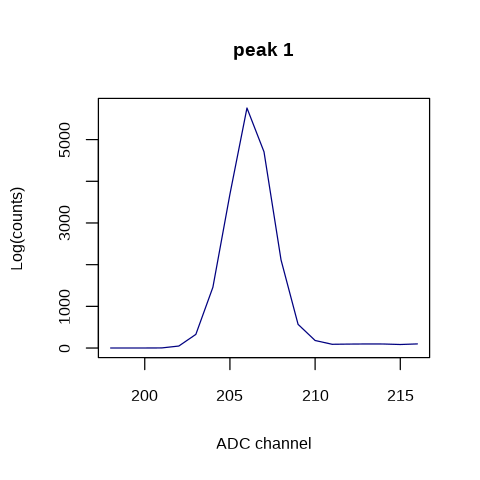

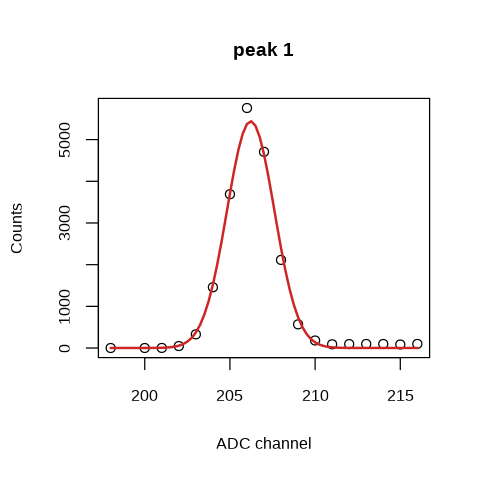

[1] "peak 2"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
A  7380.533 56.310255 1.0280799      1.0284150
B   199.276  4.240361 0.0774181      0.0774066
w     1.538  0.008311 0.0001517      0.0001482
x0  542.816  0.009720 0.0001775      0.0001704

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  7271.089 7344.128 7379.553 7417.910 7492.248
B   190.816  196.462  199.303  202.056  207.650
w     1.522    1.532    1.537    1.543    1.554
x0  542.796  542.809  542.816  542.822  542.834



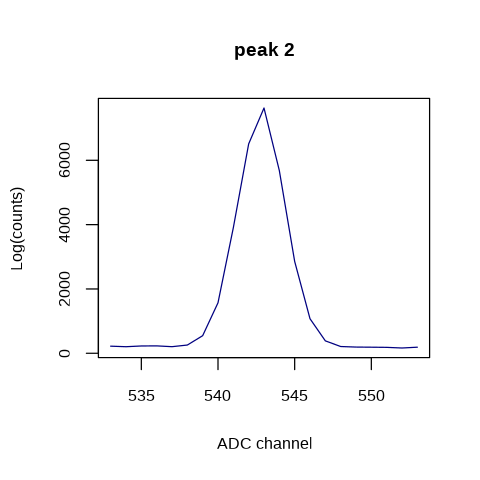

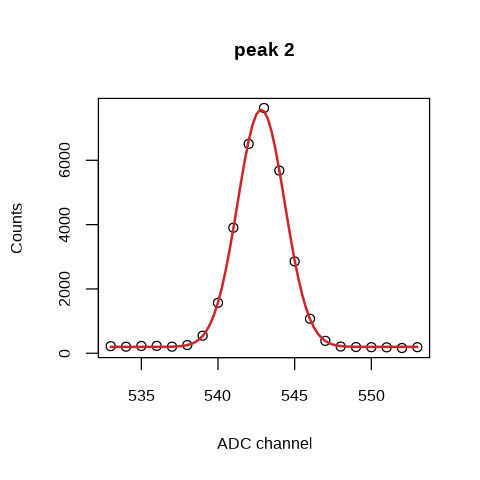

[1] "peak 3"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
A  12181.00 46.061672 0.8409672      0.8456715
B     63.37  3.001617 0.0548018      0.0537851
w      2.04  0.006213 0.0001134      0.0001162
x0  2280.30  0.008387 0.0001531      0.0001507

2. Quantiles for each variable:

        2.5%       25%      50%       75%     97.5%
A  12077.293 12150.973 12186.02 12217.379 12250.010
B     57.510    61.302    63.36    65.396    69.449
w      2.028     2.036     2.04     2.044     2.052
x0  2280.281  2280.292  2280.30  2280.304  2280.314



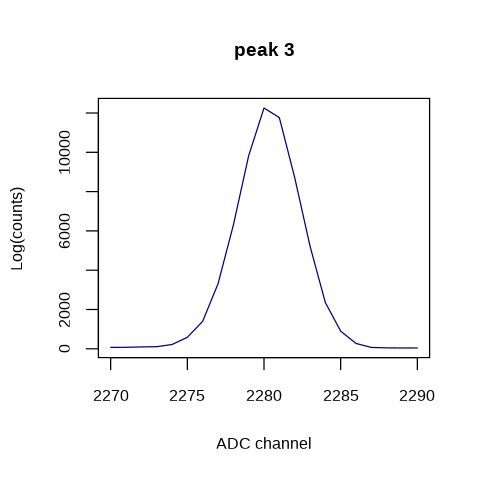

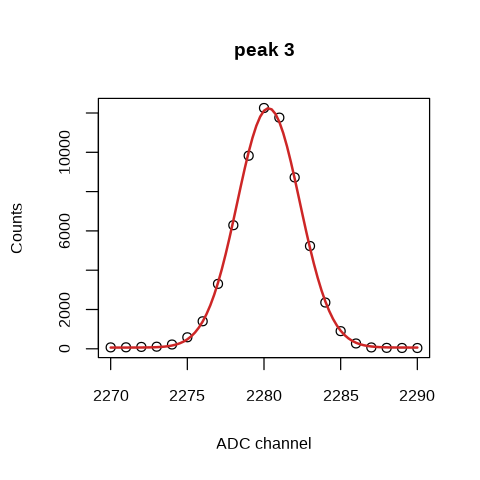

[1] "peak 4"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
A  3701.36 25.59532 0.4673046      0.4673755
B    26.51  1.22632 0.0223895      0.0223785
w     2.58  0.01281 0.0002340      0.0002278
x0 4041.47  0.01715 0.0003131      0.0003130

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  3647.394 3685.068 3703.585 3720.418 3743.192
B    23.439   25.862   26.812   27.495   27.945
w     2.556    2.571    2.579    2.588    2.606
x0 4041.433 4041.456 4041.468 4041.479 4041.501



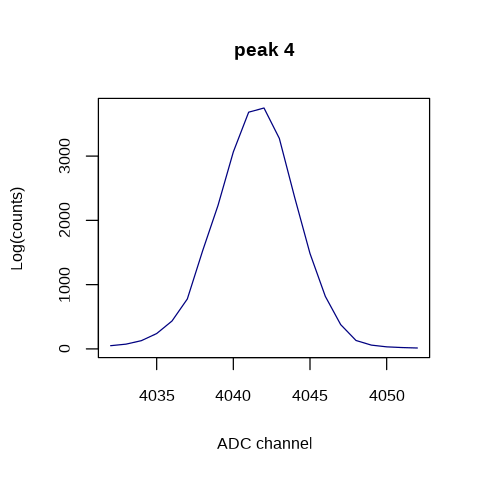

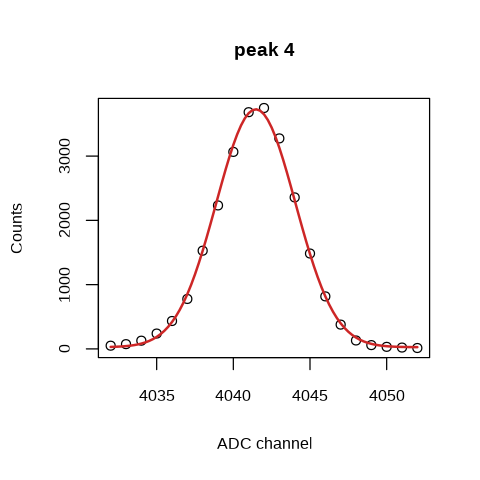

In [8]:
i=1
chains <-c()
x0_mean <-c()
x0_std <-c()

for (pk in peaks){

#Plot of the choosen peak
set_plot_dimensions(4, 4)
plot(pk$x,pk$y, type="l",
    pch = 1, cex=0.5, col="navy",
    ylab = "Log(counts)", xlab ="ADC channel",
    main=paste("peak",i))

A.min <- min(pk$y)
A.max <- max(pk$y)
B.min <- 0
B.max <- min(pk$y)   #This is a critical point for peaks that doesn't have a
                     #a stable noise around so min(pk$y) is not representative
x0.min <- min(pk$x)  
x0.max <- max(pk$x)

cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dunif(",A.min,",",A.max,")
    B ~ dunif(",B.min,",",B.max*2,")

    x0 ~ dunif(",x0.min,",",x0.max,")
    w ~ dunif(1,10)
      
}", file=paste("Models/model_peak_",i,".bug",sep=""))

model <- paste("Models/model_peak_",i,".bug",sep="")


#If multiple chains are run, each of them need to be initialized
init <- NULL;init$A  <- (A.max-A.min)/2
init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

#To have absolute control we also set the seed for and random number generator for each chain
init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


chain_number <- 3
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10


jm <- jags.model(model,
                 pk,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

#Update the Markov chain (Burn-in)
update(jm, burnin)

chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
chains <- append(chains,list(chain))

#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
#plot(chain)
print(paste("peak",i))
print(summary(chain))

A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x0_mean <- c(x0_mean,x0)
x0_std <- c(x0_std,summary(chain)$statistics[4,2])  
    
x <- seq(x0.min,x0.max,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


set_plot_dimensions(4, 4)
plot(pk$x,pk$y,
    ylab = "Counts", xlab ="ADC channel",
    main=paste("peak",i))
lines(x,f, lwd=2, col='firebrick3')
i=i+1
}

#### Americum

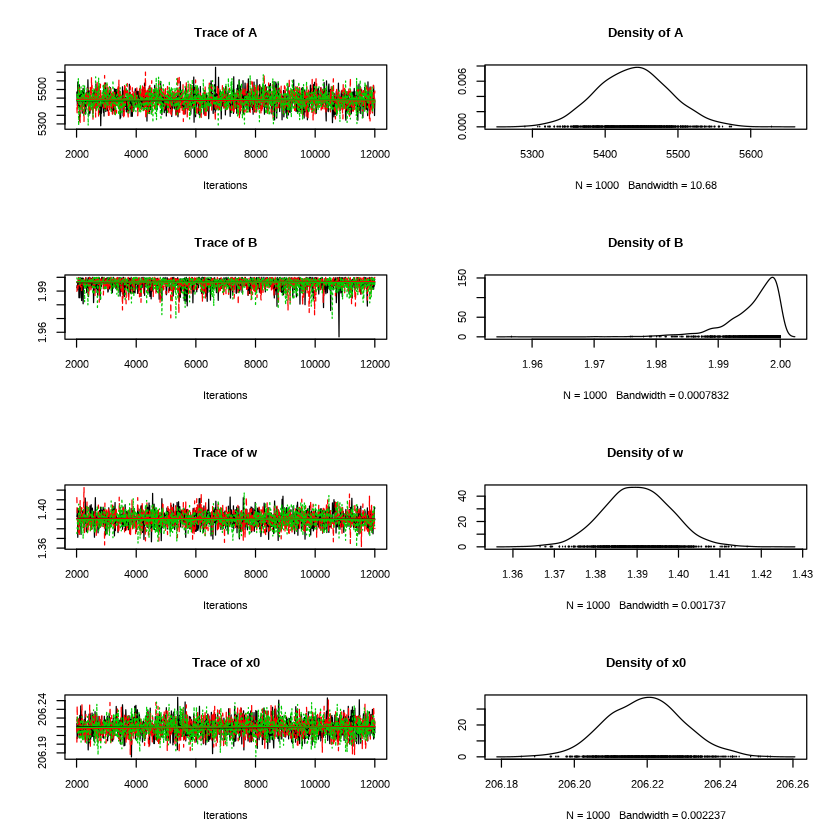

In [9]:
set_plot_dimensions(7, 7)
plot(chains[[1]])

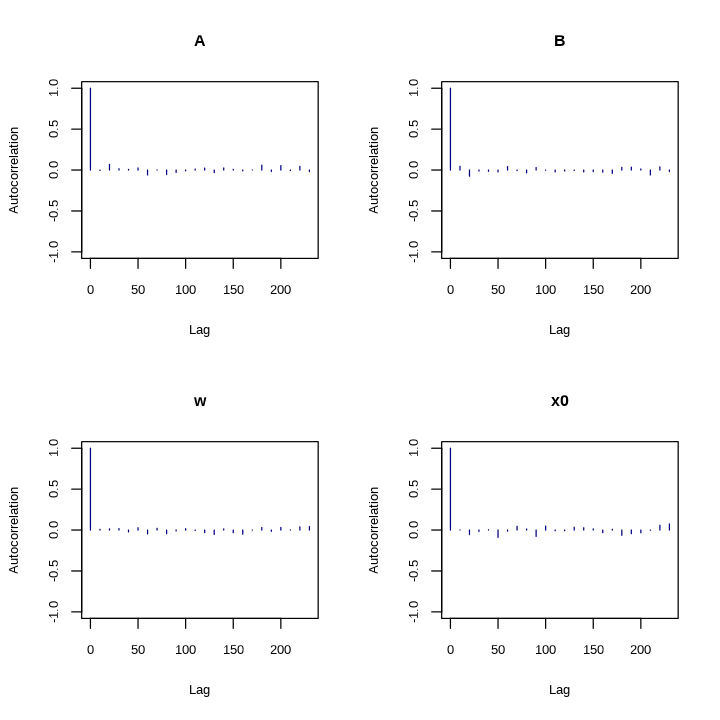

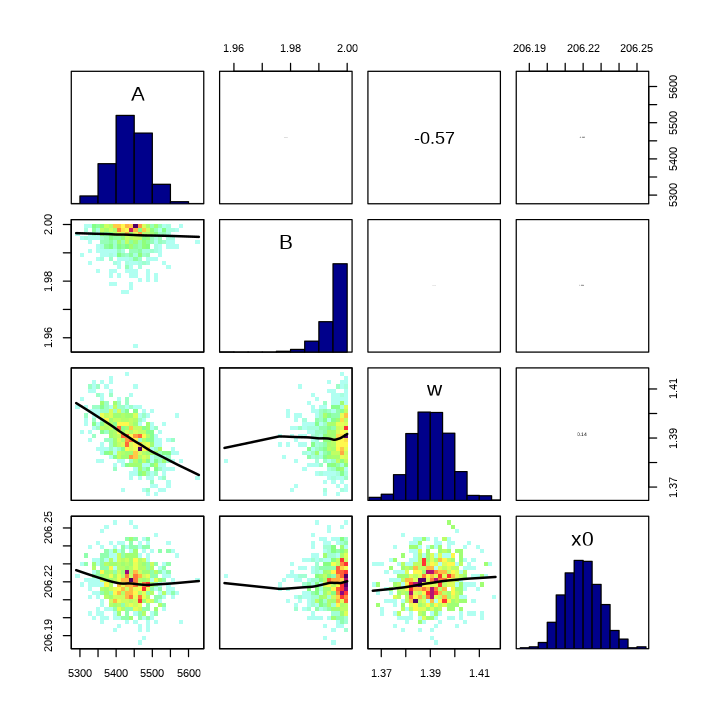

In [10]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[1]][1], col='navy')

correlationPlot((chains[[1]]))

#### Cs

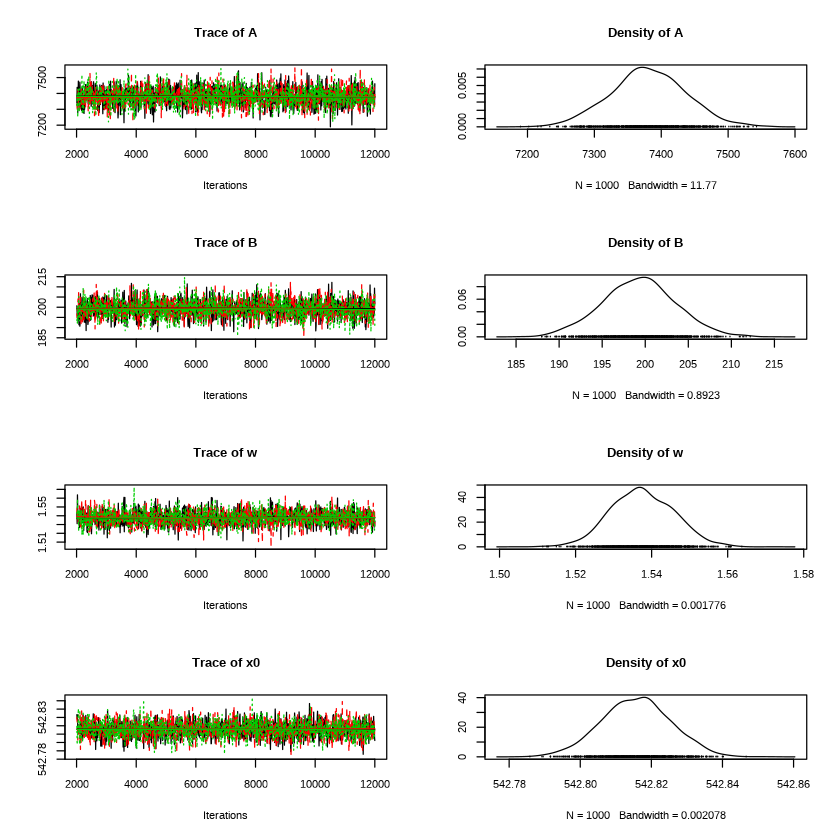

In [11]:
set_plot_dimensions(7, 7)
plot(chains[[2]])

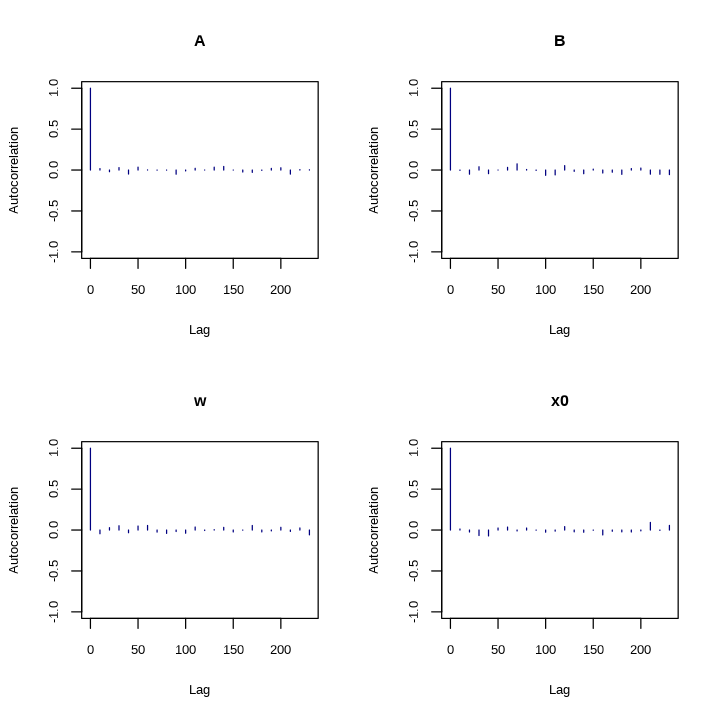

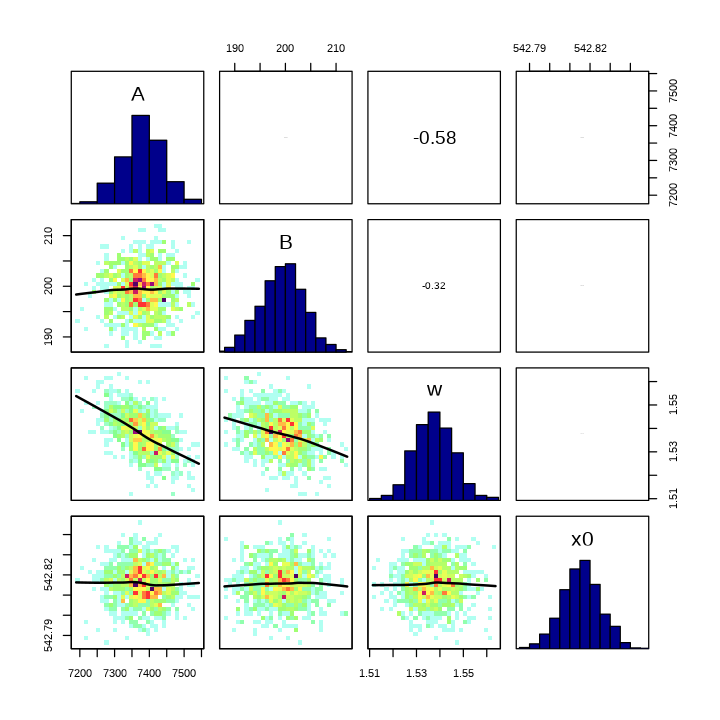

In [12]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[2]][1], col='navy')

correlationPlot((chains[[2]]))

### Co 1

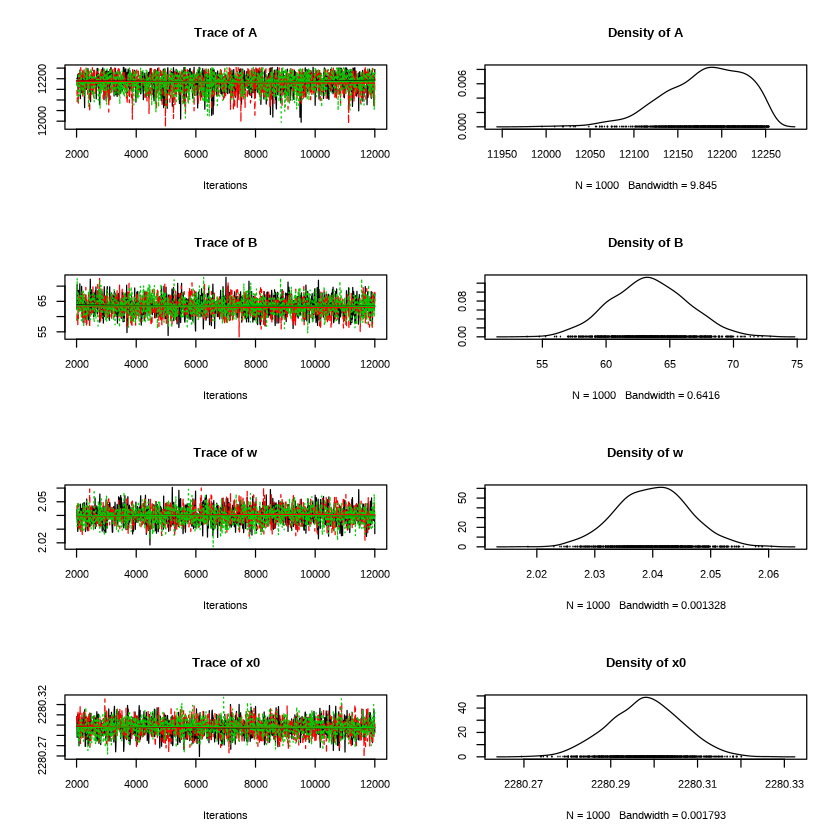

In [13]:
set_plot_dimensions(7, 7)
plot(chains[[3]])

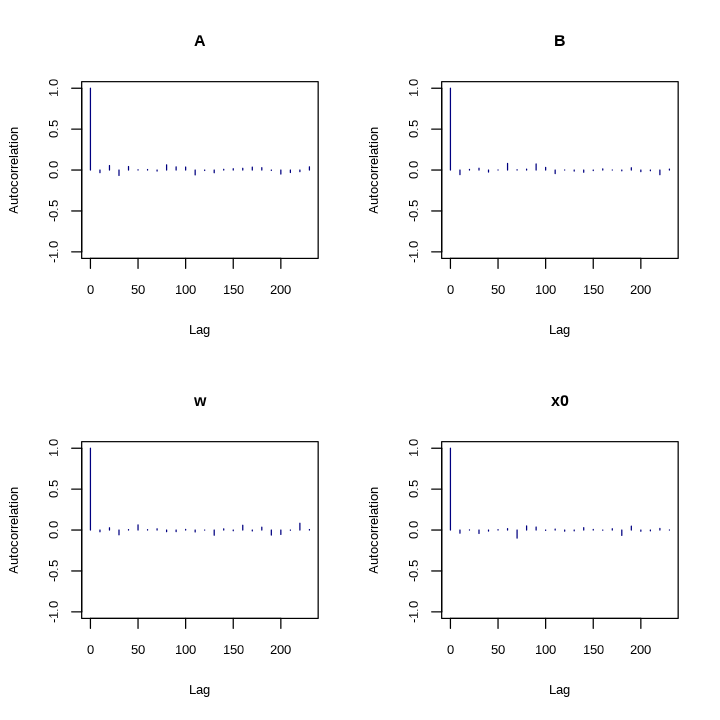

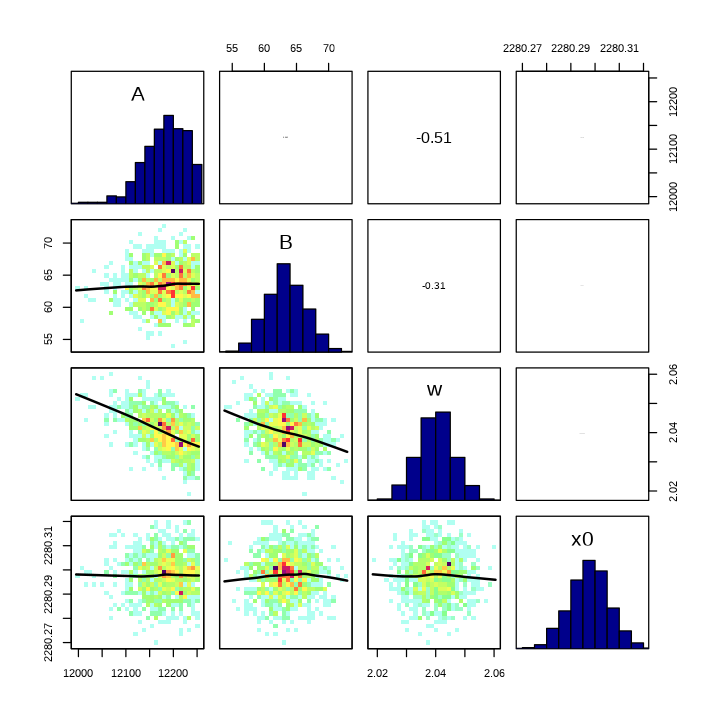

In [14]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[3]][1], col='navy')

correlationPlot((chains[[3]]))

#### Co 2


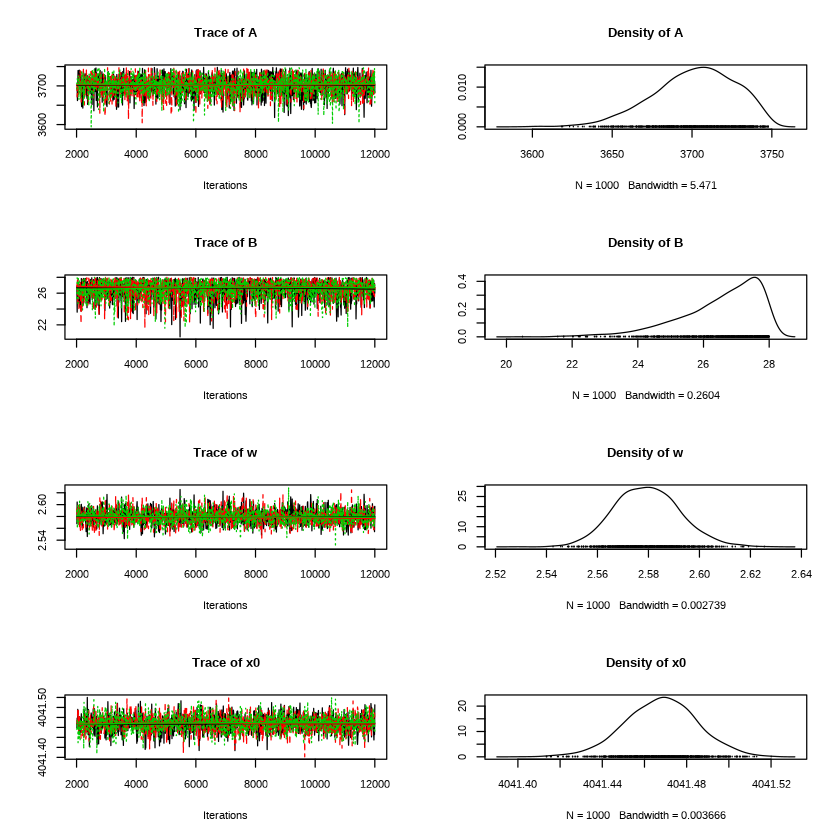

In [15]:
set_plot_dimensions(7, 7)
plot(chains[[4]])

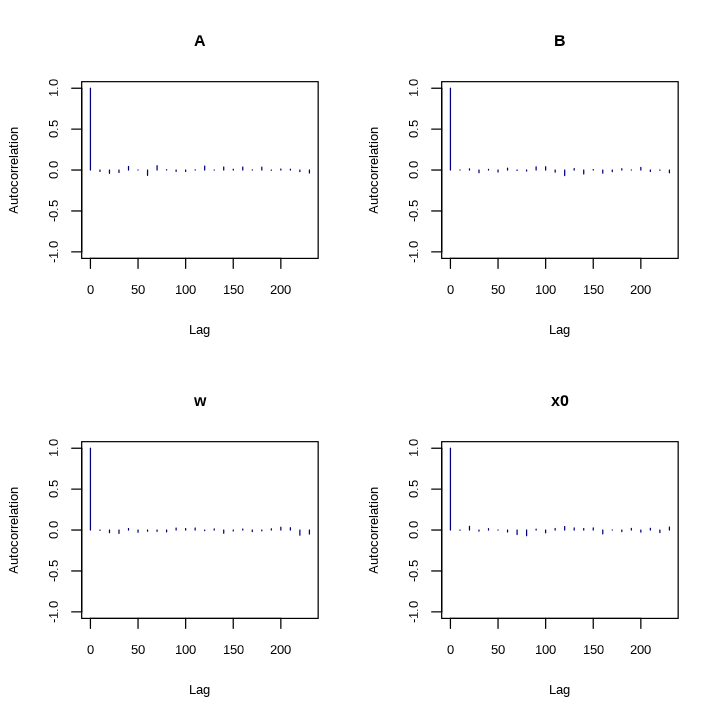

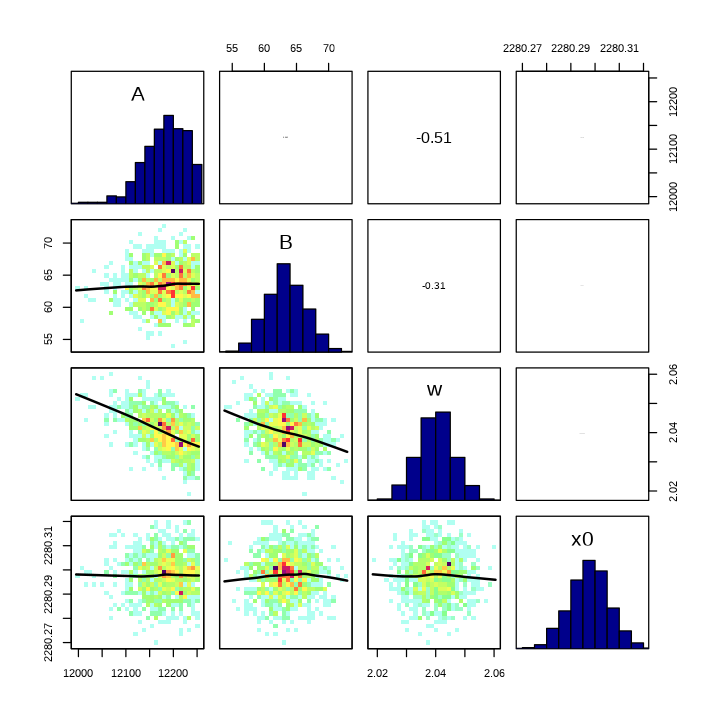

In [16]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[4]][1], col='navy')

correlationPlot((chains[[3]]))

## Energy calibration

In [17]:
peak_energy <-c(59.5409,661.657,1173.228,1332.51)


In [18]:
df <- data.frame(peak_energy,x0_mean,x0_std)
row.names(df)<-c("Am","Cs","Co_1","Co_2")

In [19]:
df

,peak_energy,x0_mean,x0_std
Am,59.5409,206.2195,0.010465177
Cs,661.6570,542.8157,0.009720385
Co_1,1173.2280,2280.2980,0.008386759
Co_2,1332.5100,4041.4679,0.017150440


In [20]:
linear_fit <- lm( df$peak_energy ~ df$x0_mean )

intercept <- as.numeric(linear_fit$coefficients[1])
slope <- as.numeric(linear_fit$coefficients[2])
ln <- intercept + data$Ch*slope

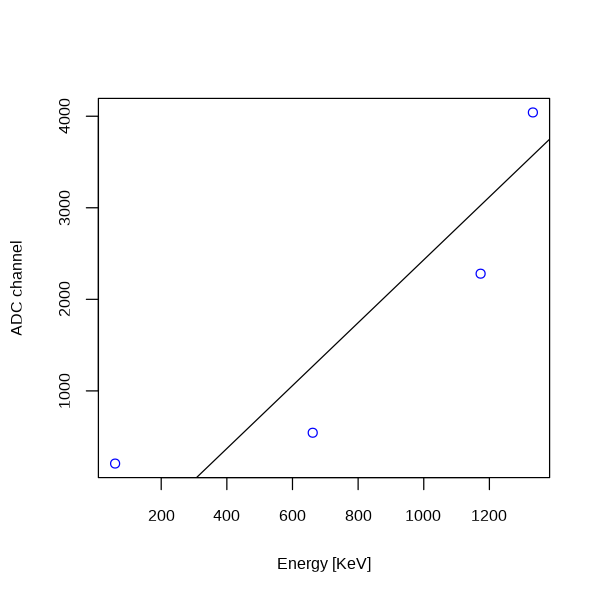

In [21]:
set_plot_dimensions(5, 5)
plot(df$peak_energy,df$x0_mean,col="blue",
    xlab="Energy [KeV]",ylab="ADC channel",
    main="")
lines(ln,data$Ch)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

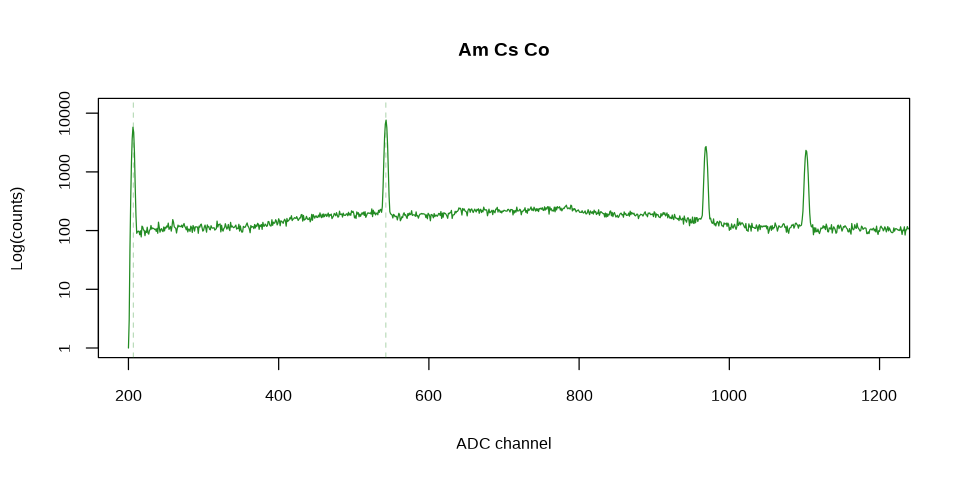

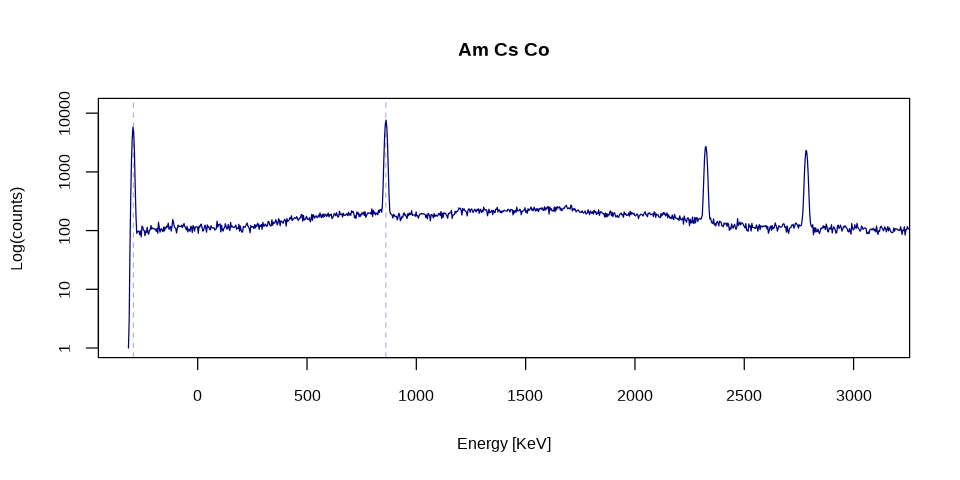

In [22]:
set_plot_dimensions(8, 4)

energy <- (data$Ch-intercept)/slope
xmin<-200;xmax<-1200
emin<-(xmin-intercept)/slope;emax<- (xmax-intercept)/slope

plot(data$Ch,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
abline(v=x0_mean[1],col="forestgreen",lty=2,lwd=0.3)
abline(v=x0_mean[2],col="forestgreen",lty=2,lwd=0.3)
abline(v=x0_mean[3],col="forestgreen",lty=2,lwd=0.3)
abline(v=x0_mean[4],col="forestgreen",lty=2,lwd=0.3)

e0_mean <- (x0_mean-intercept)/slope

plot(energy,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
abline(v=e0_mean[1],col="navy",lty=2,lwd=0.3)
abline(v=e0_mean[2],col="navy",lty=2,lwd=0.3)
abline(v=e0_mean[3],col="navy",lty=2,lwd=0.3)
abline(v=e0_mean[4],col="navy",lty=2,lwd=0.3)

## Resolution study